In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import nltk
import re
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder



from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/goncalogomes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/goncalogomes/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/goncalogomes/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [2]:
#download data
sentence = pd.read_csv("Data-20220517/training_set.txt",sep='\t',header=0)
dev_set = pd.read_csv("Data-20220517/dev_set.txt",sep='\t',header=0)

sentence.head()

,sentence,emotion
0,I'm too old to be traded in .,6
1,Mother said you could always tell a lady by he...,8
2,I always said I'd leave off when the time came .,6
3,He'll be safe with me .,2
4,Lay off .,1


## Text Exploration

### Listing Stop Words in Text

In [3]:
def word_counter(text_list):
    """
    Function that receives a list of strings and returns the (absolute) frequency of each word in that list of strings.
    """
    words_in_df = ' '.join(text_list).split()
    
    stop_words = set(stopwords.words("english"))               
    n = [w for w in words_in_df if w in stop_words]
    
    # Count all words 
    freq = pd.Series(n).value_counts()
    
    return freq
word_counter(list(sentence['sentence']))[-50:]

myself        51
does          51
through       48
haven't       46
most          44
she's         41
wasn't        41
such          40
which         39
once          38
you'd         38
same          35
few           34
having        33
against       33
while         31
yours         30
aren't        30
couldn't      27
both          25
himself       23
between       21
until         21
weren't       20
each          19
shouldn't     18
under         16
won           15
its           13
hadn't        12
ourselves     11
yourselves     8
that'll        7
further        7
nor            6
mustn't        6
ours           5
herself        5
themselves     5
hasn't         5
should've      4
itself         4
during         4
whom           3
ma             3
above          2
o              2
needn't        2
below          2
m              2
dtype: int64

### What tags exist in the sentences?

In [4]:
l = sentence.loc[sentence.sentence.str.contains('(\[\w+\])')].sentence.values
s=[]
for i in l:
    s.extend(re.findall("(\[\w+\])", i))
set(s)

{'[LOCATION]', '[PERSON]'}

### How digitis appear in sentences?

In [5]:
sentence.loc[sentence.sentence.str.contains('\d')].sentence.values[:10]

array([',000 , telegrams demanding that he yield this floor .',
       "I'll be yours if you don't kick in with that $ 10 .",
       'Did I spend 9 , years with matadors not to learn about fear and safety ?',
       'When I came here , I thought this was gonna be a 30 - day stretch , maybe 60 .',
       'They say he killed a man when he was 12 , years old .',
       "Besides , according to your story , you weren't exactly 100 % scientist after you took it .",
       'So after 129 , hours of being buried alive , at last , freedom seems in sight .',
       "We've been kicking ass for 200 , years !",
       'The hero of 50,000 , boys and 100,000 , parents .',
       "It's hard to believe that you haven't had sex for 200 , years ."],
      dtype=object)

## Words that are not in stop_words with contractions

In [6]:
l = sentence.loc[sentence.sentence.str.contains("\s\w+'\w+")].sentence.values
s=[]
for i in l:
    s.extend(re.findall("\s\w+'\w+", i))
    
stop_words = set(stopwords.words("english"))
                     
n = [w.lower().strip() for w in list(set(s)) if w.lower().strip() not in stop_words]
n[:10]

["week's",
 "headache's",
 "mill's",
 "asshole's",
 "back's",
 "da's",
 "colour's",
 "let's",
 "i'd",
 "they're"]

In [7]:
#contractions_dict = { "ain’t": "are not", "’s":" is", "aren’t": "are not", "can’t": "cannot", "can’t’ve": "cannot have", "‘cause": "because", "could’ve": "could have", "couldn’t": "could not", "couldn’t’ve": "could not have", "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have", "hasn’t": "has not", "haven’t": "have not", "he’d": "he would", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have", "how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "I’d": "I would", "I’d’ve": "I would have", "I’ll": "I will", "I’ll’ve": "I will have", "I’m": "I am", "I’ve": "I have", "isn’t": "is not", "it’d": "it would", "it’d’ve": "it would have", "it’ll": "it will", "it’ll’ve": "it will have", "let’s": "let us", "ma’am": "madam", "mayn’t": "may not", "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not", "mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock", "oughtn’t": "ought not", "oughtn’t’ve": "ought not have", "shan’t": "shall not", "sha’n’t": "shall not", "shan’t’ve": "shall not have", "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will", "she’ll’ve": "she will have", "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have", "so’ve": "so have", "that’d": "that would", "that’d’ve": "that would have", "there’d": "there would", "there’d’ve": "there would have", "they’d": "they would”, “they’d’ve": "they would have","they’ll": "they will",
 #"they’ll’ve": "they will have", "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would", "we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not","what’ll": "what will", "what’ll’ve": "what will have", "what’re": "what are", "what’ve": "what have", "when’ve": "when have", "where’d": "where did", "where’ve": "where have",
 #"who’ll": "who will", "who’ll’ve": "who will have", "who’ve": "who have", "why’ve": "why have", "will’ve": "will have", "won’t": "will not", "won’t’ve": "will not have", "would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have", "y’all’re": "you all are", "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have", "you’re": "you are", "you’ve": "you have"}

### Some word statistics

<AxesSubplot:xlabel='emotion', ylabel='text_word_count'>

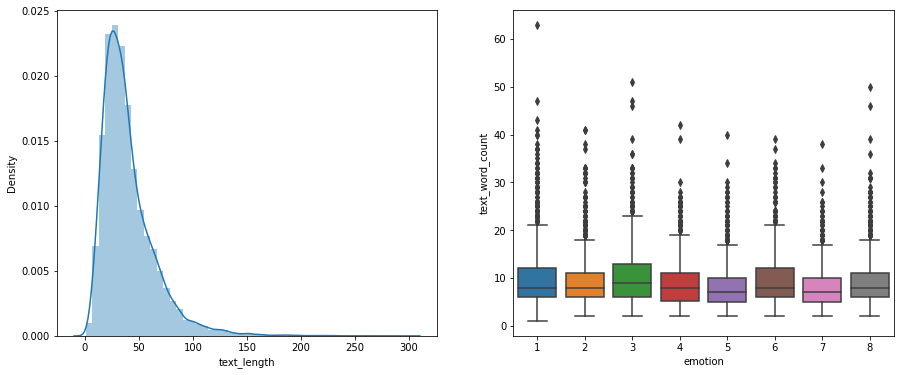

In [8]:
sentence['text_length'] = sentence['sentence'].astype(str).apply(len)
sentence['text_word_count'] = sentence['sentence'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(sentence['text_length'],ax=axes[0])
sns.boxplot(x="emotion", y="text_word_count", data=sentence,ax=axes[1])

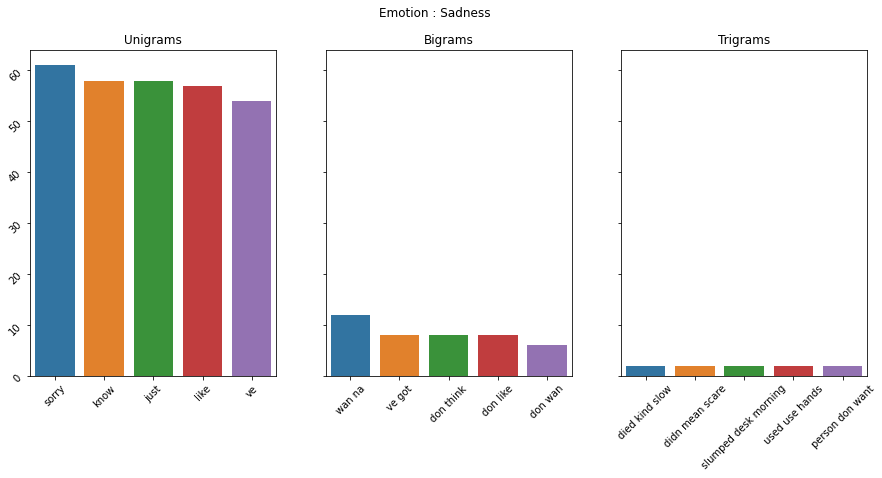

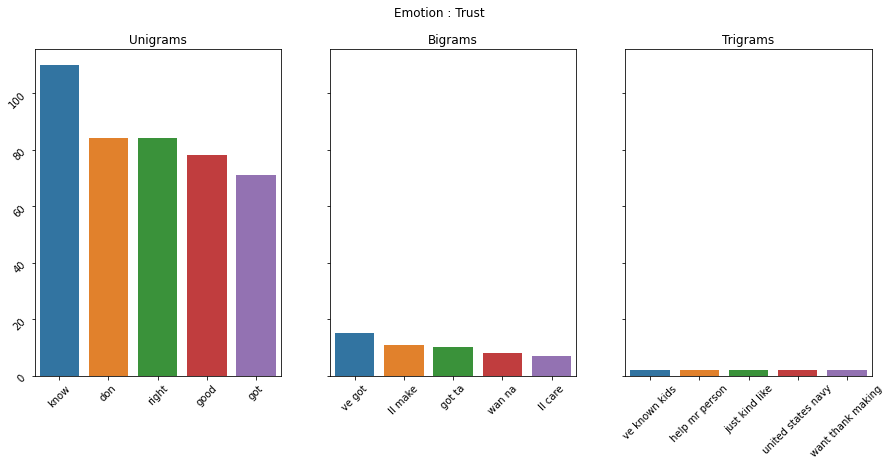

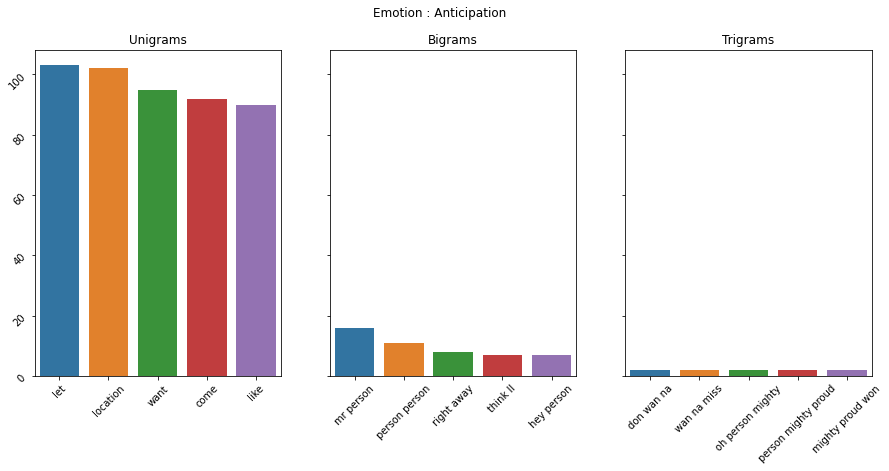

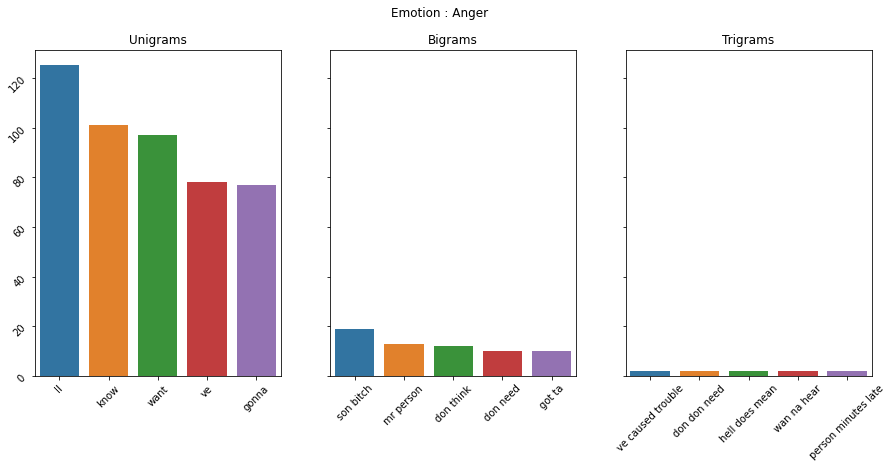

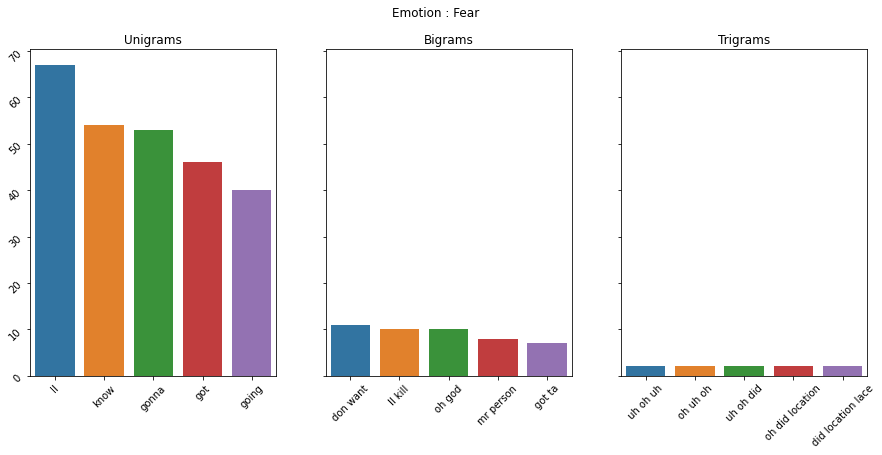

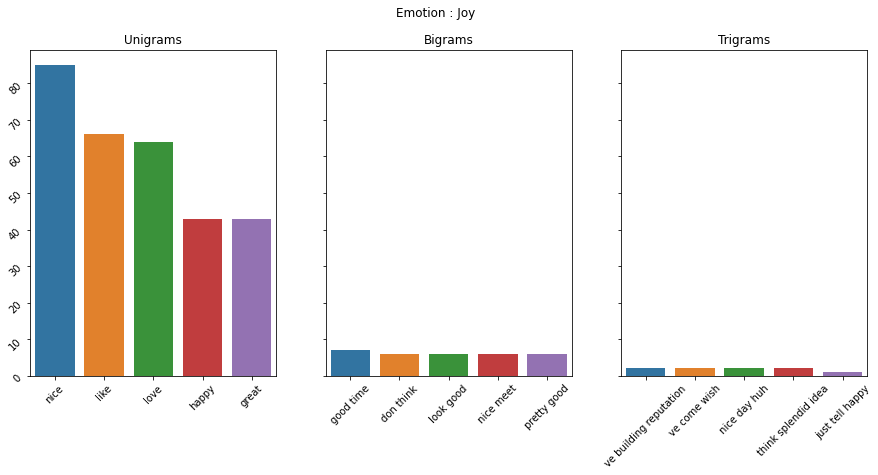

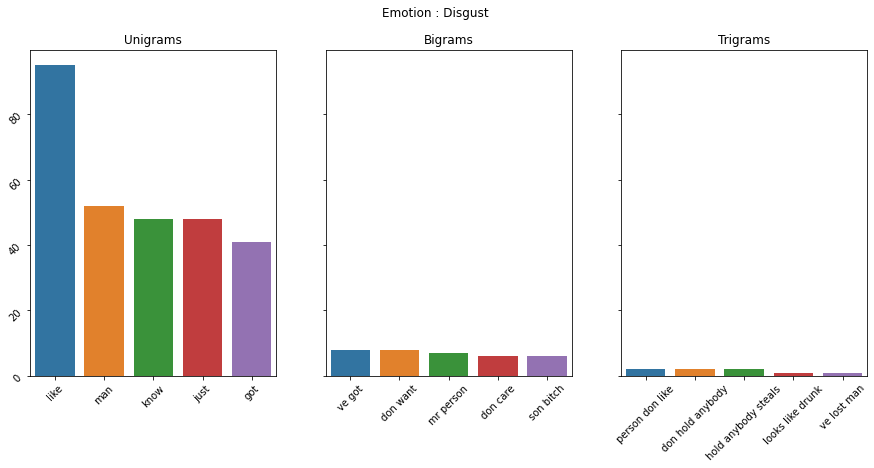

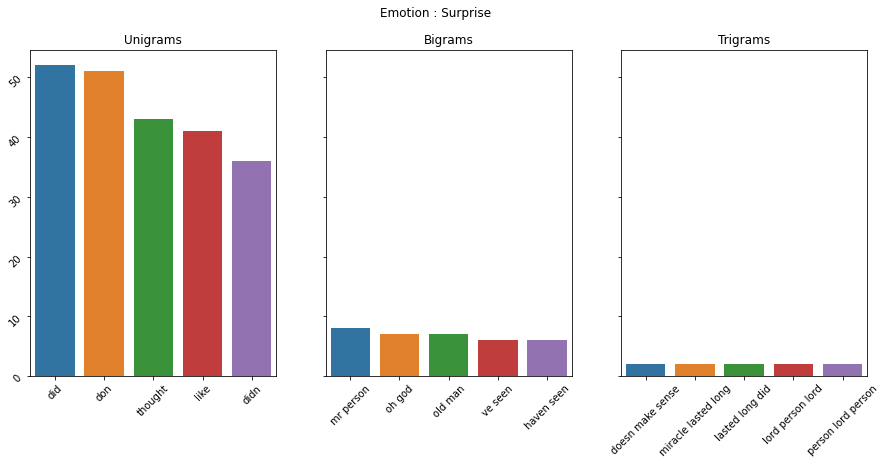

In [9]:
#adapted from https://www.kaggle.com/code/parulpandey/exploratory-data-analysis-of-the-emotion-dataset
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus) #tokenizer=preprocessing_tok
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_gram_tfidf(corpus,ngram_range,n=None):
    Tfidf = TfidfVectorizer(
            max_df=0.9,
            max_features=10000, 
            ngram_range=ngram_range,
            tokenizer=preprocessing_tok
            )
    bag_of_words = Tfidf.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def plot_count_grams(df):    
    for i in list(df.emotion.unique()):
        emo = df.loc[df.emotion==i].sentence.values
        unigrams = get_top_n_gram(emo,(1,1),7)[2:]
        bigrams = get_top_n_gram(emo,(2,2),7)[2:]
        trigrams = get_top_n_gram(emo,(3,3),7)[2:]

        condlist= [i==1,i==2,i==3,i==4,i==5,i==6,i==7,i==8]
        choicelist = ['Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust']

        fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
        fig.suptitle('Emotion : {}'.format(np.select(condlist, choicelist).item()))

        sns.barplot( list(dict(unigrams).keys()), list(dict(unigrams).values()),ax=axes[0],)
        axes[0].set_title('Unigrams')
        axes[0].tick_params(labelrotation=45)

        sns.barplot( list(dict(bigrams).keys()), list(dict(bigrams).values()),ax=axes[1],)
        axes[1].set_title('Bigrams')
        axes[1].tick_params(labelrotation=45)


        sns.barplot( list(dict(trigrams).keys()), list(dict(trigrams).values()),ax=axes[2],)
        axes[2].set_title('Trigrams')
        axes[2].tick_params(labelrotation=45)

plot_count_grams(sentence)

## Creating Classifier

In [10]:
#define preprocessing function that will be used in the TfidfVectorizer
def preprocessing_tok(text):
    '''
        This function do all the steps of preprocessing of text. It is passed in the TF-IDF vectorizer and
        receives a text and return a list with token pre processed:
        
        Input: 'I'm too old to be traded in .'
        Output: ['old', 'traded']
    '''
    processed_corpus = []
    stop_words = set(stopwords.words("english"))
    stop_words.remove('not')

    # Convert to lowercase
    text = text.lower()        
    
    # Remove punctuations
    text = re.sub('(\[location\]|\[person\]|[^a-zA-Z])', ' ', text)
    
    # Convert to list from string
    #text = text.split()
    
    # POS Tagging
    text = nltk.pos_tag(nltk.word_tokenize(text))
        # Tuple format
    #text = " ".join(str(x) for x in text)
        # Normal format
    text = " ".join(" ".join(x) for x in text)
    
    # Lemmatization
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words] 
        
    return text

In [11]:
#function that show results for several classifiers 
def Classifier_tester(X,y,x_val,y_val):
    '''
        This function train several different models for the same training set and compare results
        Input: 
            X: array matrix of features
            y: array 1d of training labels
            x_val: array matrix of features with the validation set
            y_val: array 1d with ground truth of validation labels
        Output:
            DataFrame with the results
    
    '''
    clf_list =[
              MultinomialNB(),
              BaggingClassifier (MultinomialNB()),
              BernoulliNB(),
              GaussianNB(),
              RandomForestClassifier(max_depth=5,class_weight='balanced'),
              SVC(kernel='linear'),
              KNeighborsClassifier(n_neighbors=5),
              MLPClassifier(hidden_layer_sizes=(5,5,3)),
              LogisticRegression(class_weight='balanced'),
              BaggingClassifier ( LogisticRegression(class_weight='balanced'))
             ]
    
    #save the list of category names in the order they appear in class. report.
    x = dev_set.emotion.unique()
    condlist= [x==1,x==2,x==3,x==4,x==5,x==6,x==7,x==8]
    choicelist = ['Anger','Anticipation','Disgust','Fear','Joy','Sadness','Surprise','Trust']
    category_names = list(np.select(condlist, choicelist))
    
    results = dict()
    for clf in clf_list:
        
        print('Training: ',str(clf))
    
        #train the clf
        clf.fit(X,y)

        #predict for new sentences of the dev set
        y_pred = clf.predict(x_val)
            
        #saves result in dict
        cls_rep = classification_report(y_pred, y_val, target_names=category_names,zero_division=1,output_dict=True)
        
        #delete the support metric
        cls_rep['weighted avg'].pop("support")
        
        #add the accuracy metric
        cls_rep['weighted avg'].update({'accuracy':cls_rep['accuracy']})
        
        #save the weighted avg metrics in the classifer name key
        results[str(clf)] = cls_rep['weighted avg']
        
    return pd.DataFrame(results).round(2)

In [12]:
#transforme a corpus into a Tfidf matrix (n,m) where n is the number of texts and m the words
TfidfVec = TfidfVectorizer(
            max_df=0.9,
            max_features=10000, 
            ngram_range=(1,3),
            tokenizer=preprocessing_tok
            )

#Tfidf matrix of training set
Tfidf_matrix = TfidfVec.fit_transform(sentence.sentence.values)
#Tfidf matrix of validation set
Tfidf_matrix_val = TfidfVec.transform(dev_set.sentence.values)

#smote here

#Training arrays
X= Tfidf_matrix.toarray()
y = sentence.emotion.values

#Validation arrays
x_val = Tfidf_matrix_val.toarray()
y_val = dev_set.emotion.values

Classifier_tester(X,y,x_val,y_val)

Training:  MultinomialNB()
Training:  BaggingClassifier(base_estimator=MultinomialNB())
Training:  BernoulliNB()
Training:  GaussianNB()
Training:  RandomForestClassifier(class_weight='balanced', max_depth=5)
Training:  SVC(kernel='linear')
Training:  KNeighborsClassifier()
Training:  MLPClassifier(hidden_layer_sizes=(5, 5, 3))
Training:  LogisticRegression(class_weight='balanced')
Training:  BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced'))


,MultinomialNB(),BaggingClassifier(base_estimator=MultinomialNB()),BernoulliNB(),GaussianNB(),"RandomForestClassifier(class_weight='balanced', max_depth=5)",SVC(kernel='linear'),KNeighborsClassifier(),"MLPClassifier(hidden_layer_sizes=(5, 5, 3))",LogisticRegression(class_weight='balanced'),BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced'))
precision,0.62,0.60,0.31,0.55,0.30,0.47,0.36,0.36,0.32,0.32
recall,0.31,0.30,0.24,0.14,0.23,0.35,0.29,0.30,0.30,0.31
f1-score,0.36,0.36,0.24,0.18,0.23,0.38,0.31,0.32,0.30,0.31
accuracy,0.31,0.30,0.24,0.14,0.23,0.35,0.29,0.30,0.30,0.31


In [13]:
dev_set.loc[dev_set.sentence.apply(lambda x: len(preprocessing_tok(x)))==0]

,sentence,emotion
58,[PERSON] ... ?,7


1. Terminar analise exploratoria de palavras (grafico com score tfidf e ver. palavras estranhas) (Lucas)
2. Adicionar SMOTE com o tf-idf no código para teste (João)
3. Testar POS nos modelos (Gonçalo)
4. Fine Tuning o melhor algoritmo (Tomás)